<a href="https://colab.research.google.com/github/Valeriss2005/Mack2025/blob/main/Variaveis_Tradicionais_%2B_Bem_estar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Valéria Souza - Jun/25

Este código é utilizado para os experimentos 1- Variáveis Tradicionais **com adição de variáveis de bem-estar** com composição mínima e experimento 2 - Variáveis Tradicionais com adição de variáveis de bem-estar com  composição ideal. O ajuste é feito nos pesos da seção 7 (60000,50000,40000) para composição mínima e (6000000,5000000,4000000) para composição máxima.

In [ ]:
# Seção 0 - Instala o Pulp
!pip install pulp

In [ ]:
# Seção 1 - Importa bibliotecas para manipulação de dados, distâncias, otimização e visualização.

import os
import pandas as pd
from geopy.distance import geodesic
from pulp import *
from datetime import datetime
import time
import matplotlib.pyplot as plt
import networkx as nx

In [ ]:
# Seção 2 - Carrega os dados dos funcionários, projetos, clientes e restrições em dataframes.
def carregar_tabelas(caminho):
    tabelas = {}
    for arquivo in os.listdir(caminho):
        if arquivo.endswith(".csv"):
            nome = arquivo.replace(".csv", "")
            tabelas[nome] = pd.read_csv(os.path.join(caminho, arquivo), sep=";")
    return tabelas

path_bases = "/content"
bases = carregar_tabelas(path_bases)

# Seção 3 - Dataframes
df_func = bases["TbFuncionarios"]
df_proj = bases["TbProjetos"]
df_categorias = bases["TbCategorias"]
df_cli = bases["TbClientes"]
df_aloc = bases["TbProjetos_Alocacao"]
df_skills = bases["TbFuncionarios_Skill"]
df_composicao_real = df_composicao_real = bases["TbComposicao"]
df_indisp = bases["TbFuncionarios_Indisponiveis"]
df_trein_func = bases["TbFuncionarios_Treinamentos"]
df_trein_obrig = bases["TbProjetos_Treinamentos_Obrigatorios"]

df_autoex = bases["TbProjetos_Autoexclusao"]
df_desco = bases["TbProjetos_Descompressao"]

In [ ]:
# Seção 3 - Faz tratamento dos dados, ajustando formatos de datas e campos numéricos.

for col in ["Salario_Hora"]:
    df_func[col] = df_func[col].astype(str).str.replace(",", ".").astype(float)
df_proj["Qt_horas_Previstas"] = df_proj["Qt_horas_Previstas"].astype(str).str.replace(",", ".").astype(float)
df_proj["Data_Inicio_Proj"] = pd.to_datetime(df_proj["Data_Inicio_Proj"], dayfirst=True)
df_proj["Data_Fim_Proj"] = pd.to_datetime(df_proj["Data_Fim_Proj"], dayfirst=True)
df_composicao_real["Qtd_Ideal"] = df_composicao_real["Qtd_Ideal"].astype(int)
df_trein_func["Valido_Ate"] = pd.to_datetime(df_trein_func["Valido_Ate"], errors='coerce', dayfirst=True)
df_indisp["Data_Inicio"] = pd.to_datetime(df_indisp["Data_Inicio_Indisp"], errors='coerce', dayfirst=True)
df_indisp["Data_Fim"] = pd.to_datetime(df_indisp["Data_Fim_Indisp"], errors='coerce', dayfirst=True)
df_desco["Data_Inicio"] = pd.to_datetime(df_desco["Data_Inicio_Desco"], errors='coerce', dayfirst=True)
df_desco["Data_Fim"] = pd.to_datetime(df_desco["Data_Fim_Desco"], errors='coerce', dayfirst=True)

In [ ]:
# Seção 5 - Cria todas as combinações funcionário-projeto, considerando filtros de regras e restrições.

def gerar_combinacoes(df_func, df_proj, df_cli, df_categorias, df_skills):
    skills_por_func = df_skills.groupby("ID_Func").size().reset_index(name="Qtd_Skills")
    df_func = df_func.merge(skills_por_func, on="ID_Func", how="left")
    df_func["Qtd_Skills"] = df_func["Qtd_Skills"].fillna(0).astype(int)

    lista_comb = []
    for _, projeto in df_proj.iterrows():
        id_proj = projeto["ID_Proj"]
        id_cli = projeto["ID_Cli"]
        data_ini = projeto["Data_Inicio_Proj"]
        data_fim = projeto["Data_Fim_Proj"]
        qt_horas_proj = projeto["Qt_horas_Previstas"]

        for _, func in df_func.iterrows():
            cat_id = func["ID_Categ"]
            perc_tempo_cat = df_categorias.loc[df_categorias["ID_Categ"] == cat_id, "Perc_Tempo_Proj"].values[0]
            lat_func = float(str(func["Latitude_Func"]).replace(',', '.'))
            lon_func = float(str(func["Longitude_Func"]).replace(',', '.'))
            lat_cli = float(str(df_cli.loc[df_cli["ID_Cli"] == id_cli, "Latitude_Cli"].values[0]).replace(',', '.'))
            lon_cli = float(str(df_cli.loc[df_cli["ID_Cli"] == id_cli, "Longitude_Cli"].values[0]).replace(',', '.'))

            dist = geodesic((lat_func, lon_func), (lat_cli, lon_cli)).km
            if dist > 50:
                continue

            if not df_indisp[(df_indisp["ID_Func"] == func["ID_Func"]) &
                              (~((data_ini > df_indisp["Data_Fim"]) | (data_fim < df_indisp["Data_Inicio"])))].empty:
                continue

        # inclusão bem-estar
            if not df_autoex[(df_autoex["ID_Proj"] == id_proj) & (df_autoex["ID_Func"] == func["ID_Func"])].empty:
                continue
            if not df_desco[(df_desco["ID_Proj"] == id_proj) & (df_desco["ID_Func"] == func["ID_Func"])].empty:
                continue

            treinos_obrig = df_trein_obrig[df_trein_obrig["ID_Proj"] == id_proj]["ID_Treino"].tolist()
            treinos_validos = df_trein_func[(df_trein_func["ID_Func"] == func["ID_Func"]) &
                                            (df_trein_func["Valido_Ate"] >= data_fim)]["ID_Treino"].tolist()
            if not set(treinos_obrig).issubset(set(treinos_validos)):
                continue

            lista_comb.append({
                "ID_Func": func["ID_Func"],
                "ID_Categ_Real": cat_id,
                "ID_Categ_Upgrade": cat_id,
                "ID_Proj": id_proj,
                "ID_Categ": cat_id,
                "Salario_Hora": func["Salario_Hora"],
                "Qt_horas_Previstas": qt_horas_proj,
                "Perc_Tempo_Proj": perc_tempo_cat,
                "Data_Inicio_Proj": data_ini,
                "Data_Fim_Proj": data_fim,
                "Distancia": dist
            })

            if func["Qtd_Skills"] >= 3 and cat_id in [6, 5, 4]:
                cat_superior = cat_id - 1
                if cat_superior >= 1:
                    perc_tempo_sup = df_categorias.loc[df_categorias["ID_Categ"] == cat_superior, "Perc_Tempo_Proj"].values[0]
                    lista_comb.append({
                        "ID_Func": func["ID_Func"],
                        "ID_Categ_Real": cat_id,
                        "ID_Categ_Upgrade": cat_superior,
                        "ID_Proj": id_proj,
                        "ID_Categ": cat_superior,
                        "Salario_Hora": func["Salario_Hora"],
                        "Qt_horas_Previstas": qt_horas_proj,
                        "Perc_Tempo_Proj": perc_tempo_sup,
                        "Data_Inicio_Proj": data_ini,
                        "Data_Fim_Proj": data_fim,
                        "Distancia": dist
                    })

    df_comb = pd.DataFrame(lista_comb)
    df_comb["Custo"] = df_comb["Salario_Hora"] * df_comb["Qt_horas_Previstas"] * df_comb["Perc_Tempo_Proj"] / 100
    return df_comb

combinacoes_validas = gerar_combinacoes(df_func, df_proj, df_cli, df_categorias, df_skills)


In [ ]:
# Seção 6 - Cria variáveis binárias de decisão para indicar alocações e ativação de projetos.

prob = LpProblem("Alocacao_Projetos_Real", LpMinimize)
combinacoes_validas["varname"] = combinacoes_validas.apply(lambda row: f"x_{row['ID_Func']}_{row['ID_Proj']}", axis=1)
vars_dict = LpVariable.dicts("x", (row["varname"] for _, row in combinacoes_validas.iterrows()), cat="Binary")

ids_projetos = combinacoes_validas["ID_Proj"].unique().tolist()
projetos_ativos = LpVariable.dicts("y", ids_projetos, cat="Binary")

# Custo
custo_total = lpSum(vars_dict[row["varname"]] * row["Custo"] for _, row in combinacoes_validas.iterrows())
penalidade_projetos_nao_alocados = lpSum((1 - projetos_ativos[j]) * 1_000_000 for j in ids_projetos)

In [ ]:
# Seção 7 - Cria variáveis de desvio e penalidades para incentivar aderência à composição ideal.

desvio_vars = {}
penalidade_desvio = 0
for proj_id in ids_projetos:
    composicao_proj = df_composicao_real[df_composicao_real["ID_Proj"] == proj_id]
    for _, linha in composicao_proj.iterrows():
        cat = linha["ID_Categ"]
        varname = f"desvio_{proj_id}_{cat}"
        desvio_var = LpVariable(varname, lowBound=0, cat="Continuous")
        desvio_vars[(proj_id, cat)] = desvio_var
        grupo_proj = combinacoes_validas[(combinacoes_validas["ID_Proj"] == proj_id) & (combinacoes_validas["ID_Categ_Upgrade"] == cat)]
        qtd_alocada = lpSum(vars_dict[row["varname"]] for _, row in grupo_proj.iterrows())
        ideal = linha["Qtd_Ideal"]
        cat = linha["ID_Categ"]

        # Aumentar penalidade artificialmente - quanto mais aumento, mais pessoas são alocadas para o projeto.
        if cat == 4:
            peso = 6000000
        elif cat == 5:
            peso = 5000000
        elif cat == 6:
            peso = 4000000
        else:
            peso = linha["Peso_Penalidade"]
        prob += desvio_var >= qtd_alocada - ideal
        prob += desvio_var >= ideal - qtd_alocada
        penalidade_desvio += peso * desvio_var


In [ ]:
# Seção 8 - Define a função objetivo combinando custo, penalidade por desvio e projetos não alocados.

prob += custo_total + penalidade_desvio + penalidade_projetos_nao_alocados

In [ ]:
# Seção 9 - Aplica restrições de composição mínima, limite por projeto e máximo de projetos por pessoa.

for proj_id in ids_projetos:
    grupo_proj = combinacoes_validas[combinacoes_validas["ID_Proj"] == proj_id]
    socios = grupo_proj[grupo_proj["ID_Categ_Upgrade"] == 1]
    dir_ou_sm = grupo_proj[grupo_proj["ID_Categ_Upgrade"].isin([2, 3])]
    prob += lpSum(vars_dict[row["varname"]] for _, row in socios.iterrows()) >= projetos_ativos[proj_id]
    prob += lpSum(vars_dict[row["varname"]] for _, row in dir_ou_sm.iterrows()) >= projetos_ativos[proj_id]

for proj_id in ids_projetos:
    max_p = df_proj[df_proj["ID_Proj"] == proj_id]["Max_Pessoas"].values[0]
    grupo_proj = combinacoes_validas[combinacoes_validas["ID_Proj"] == proj_id]

    obrigatorios = grupo_proj[grupo_proj["ID_Categ_Upgrade"].isin([1, 2, 3])]
    complementares = grupo_proj[grupo_proj["ID_Categ_Upgrade"].isin([4, 5, 6])]

    prob += lpSum(vars_dict[row["varname"]] for _, row in complementares.iterrows()) >= projetos_ativos[proj_id]

    prob += lpSum(vars_dict[row["varname"]] for _, row in obrigatorios.iterrows()) + \
            lpSum(vars_dict[row["varname"]] for _, row in complementares.iterrows()) <= max_p

# Vínculo x <= y
for i, row in combinacoes_validas.iterrows():
    prob += vars_dict[row["varname"]] <= projetos_ativos[row["ID_Proj"]]

contagem_aloc_atual = df_aloc.groupby("ID_Func")["ID_Proj"].nunique().to_dict()
limite_projetos = {1: 8, 2: 8, 3: 5, 4: 5, 5: 5, 6: 5}
for func_id, grupo_func in combinacoes_validas.groupby("ID_Func"):
    categoria_real = grupo_func["ID_Categ_Real"].values[0]
    limite = limite_projetos.get(categoria_real, 5)
    aloc_atual = contagem_aloc_atual.get(func_id, 0)
    prob += lpSum(vars_dict[row["varname"]] for _, row in grupo_func.iterrows()) + aloc_atual <= limite

In [ ]:
# Seção 10 - # Executa o solver HiGHS, resolve o modelo e exibe o status e resultados principais.

solver = HiGHS(msg=True, timeLimit=600, gapRel=0.01)
t_start = time.time()
status = prob.solve(solver)
t_end = time.time()

In [ ]:
# Seção 11 -  Marca as combinações que foram selecionadas na solução ótima.

# Custo real consistente com o consolidado
df_ativadas = combinacoes_validas[combinacoes_validas["varname"].isin(
    [k for k, v in vars_dict.items() if v.varValue == 1]
)]

df_consolidado_temp = df_ativadas.sort_values(by="Custo").drop_duplicates(subset=["ID_Func", "ID_Proj"], keep="first")

custo_total_real = df_consolidado_temp["Custo"].sum()

print("="*60)
print("RESULTADOS DO SOLVER")
print("="*60)
print(f"Status do Solver: {LpStatus[status]}")
print(f"Projetos Alocados: {sum(projetos_ativos[p].varValue for p in ids_projetos)}")
print(f"Total de Alocações: {df_consolidado_temp.shape[0]}")
print(f"Custo Total das Alocações (Consolidado): R$ {custo_total_real:,.2f}")
print(f"Custo Total com Penalidades: R$ {value(prob.objective):,.2f}")
print(f"Tempo de execução: {(t_end - t_start) / 60:.2f} minutos")
print("="*60)


RESULTADOS DO SOLVER
Status do Solver: Optimal
Projetos Alocados: 200.0
Total de Alocações: 679
Custo Total das Alocações (Consolidado): R$ 49,820,203.44
Custo Total com Penalidades: R$ 3,662,887,592.40
Tempo de execução: 0.90 minutos


In [ ]:
# Seção 12 - Cria o dataframe final com as alocações realizadas e se houve promoção funcional.

combinacoes_validas["alocado"] = combinacoes_validas["varname"].apply(
    lambda x: vars_dict[x].varValue if x in vars_dict else 0
)


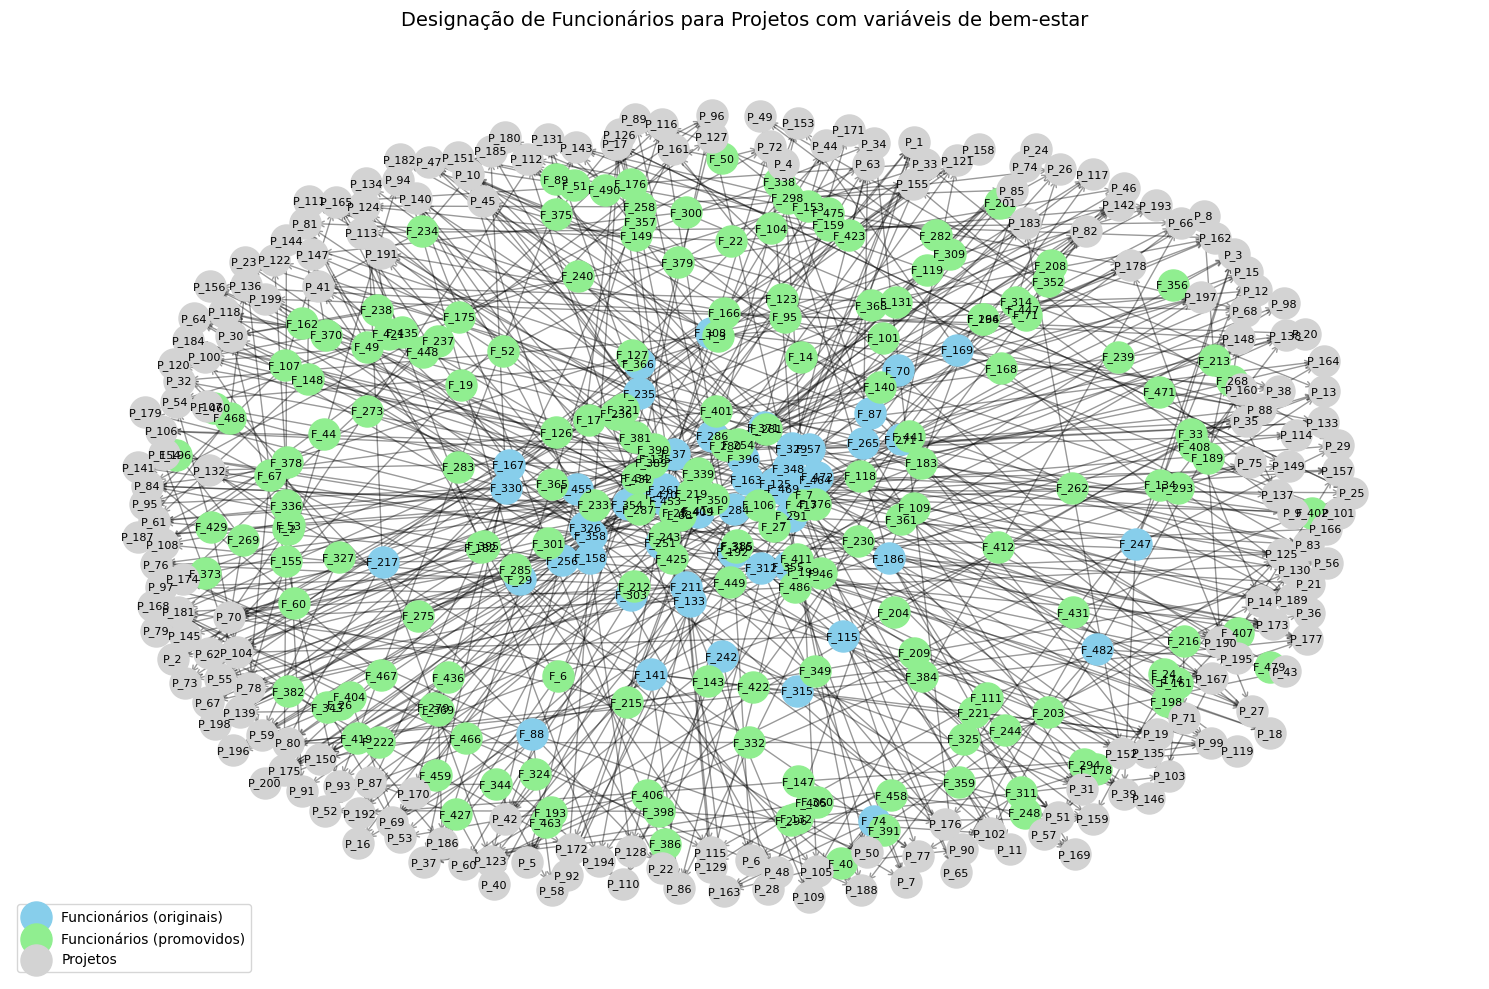

In [ ]:
# Seção 13 - Gera um grafo que mostra visualmente as alocações entre funcionários e projetos.

df_alocados = combinacoes_validas[combinacoes_validas["alocado"] == 1].copy()
df_alocados["Promocao_Funcional"] = df_alocados["ID_Categ_Real"] > df_alocados["ID_Categ_Upgrade"]

G = nx.DiGraph()

func_promovidos = df_alocados[df_alocados["Promocao_Funcional"]]["ID_Func"].unique()
func_nao_promovidos = df_alocados[~df_alocados["ID_Func"].isin(func_promovidos)]["ID_Func"].unique()

func_nos_prom = [f"F_{f}" for f in func_promovidos]
func_nos_nao = [f"F_{f}" for f in func_nao_promovidos]
proj_nos = [f"P_{p}" for p in df_alocados["ID_Proj"].unique()]

G.add_nodes_from(func_nos_prom, bipartite=0)
G.add_nodes_from(func_nos_nao, bipartite=0)
G.add_nodes_from(proj_nos, bipartite=1)

for _, row in df_alocados.iterrows():
    G.add_edge(f"F_{row['ID_Func']}", f"P_{row['ID_Proj']}", weight=row["Custo"])

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=0.65, seed=42)

nx.draw_networkx_nodes(G, pos, nodelist=func_nos_nao, node_color="skyblue", label="Funcionários (originais)", node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=func_nos_prom, node_color="lightgreen", label="Funcionários (promovidos)", node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=proj_nos, node_color="lightgray", label="Projetos", node_size=500)

nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='->', alpha=0.4)
#edge_labels = {(u, v): f'R$ {d["weight"]:.0f}' for u, v, d in G.edges(data=True)}
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Designação de Funcionários para Projetos com variáveis de bem-estar", fontsize=14)
plt.axis("off")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

In [ ]:
# Seção 14- Gera um relatório detalhado em CSV para conferência manual da solução encontrada.

df_indisp = bases["TbFuncionarios_Indisponiveis"]
df_trein_func = bases["TbFuncionarios_Treinamentos"]
df_trein_obrig = bases["TbProjetos_Treinamentos_Obrigatorios"]
df_autoex = bases["TbProjetos_Autoexclusao"]
df_descomp = bases["TbProjetos_Descompressao"]

df_indisp["Data_Inicio"] = pd.to_datetime(df_indisp["Data_Inicio_Indisp"], errors='coerce', dayfirst=True)
df_indisp["Data_Fim"] = pd.to_datetime(df_indisp["Data_Fim_Indisp"], errors='coerce', dayfirst=True)
df_descomp["Data_Inicio"] = pd.to_datetime(df_descomp["Data_Inicio_Desco"], errors='coerce', dayfirst=True)
df_descomp["Data_Fim"] = pd.to_datetime(df_descomp["Data_Fim_Desco"], errors='coerce', dayfirst=True)
df_trein_func["Valido_Ate"] = pd.to_datetime(df_trein_func["Valido_Ate"], errors='coerce', dayfirst=True)

df_alocados["Promocao_Funcional"] = df_alocados["ID_Categ_Real"] > df_alocados["ID_Categ_Upgrade"]

df_verificacao = df_alocados.merge(df_func, on="ID_Func", how="left") \
    .merge(df_proj, on="ID_Proj", how="left") \
    .merge(df_categorias, left_on="ID_Categ_Upgrade", right_on="ID_Categ", how="left") \
    .merge(df_cli, on="ID_Cli", how="left")

df_verificacao["Latitude_Func"] = df_verificacao["Latitude_Func"].astype(str).str.replace(",", ".").astype(float)
df_verificacao["Longitude_Func"] = df_verificacao["Longitude_Func"].astype(str).str.replace(",", ".").astype(float)
df_verificacao["Latitude_Cli"] = df_verificacao["Latitude_Cli"].astype(str).str.replace(",", ".").astype(float)
df_verificacao["Longitude_Cli"] = df_verificacao["Longitude_Cli"].astype(str).str.replace(",", ".").astype(float)
df_verificacao["Distancia_Calculada"] = df_verificacao.apply(
    lambda row: geodesic((row["Latitude_Func"], row["Longitude_Func"]),
                         (row["Latitude_Cli"], row["Longitude_Cli"])), axis=1)

col_salario = [col for col in df_verificacao.columns if "Salario_Hora" in col][0]
col_qt_horas = [col for col in df_verificacao.columns if "Qt_horas_Previstas" in col][0]
col_perc_tempo = [col for col in df_verificacao.columns if "Perc_Tempo_Proj" in col][0]
col_data_fim_proj = [col for col in df_verificacao.columns if "Data_Fim_Proj" in col][0]

df_verificacao["Custo_Calculado"] = df_verificacao[col_salario].astype(str).str.replace(",", ".").astype(float) * \
                                    df_verificacao[col_qt_horas].astype(str).str.replace(",", ".").astype(float) * \
                                    df_verificacao[col_perc_tempo].astype(str).str.replace(",", ".").astype(float) / 100

def verificar_treinamentos(row):
    obrigatorios = df_trein_obrig[df_trein_obrig["ID_Proj"] == row["ID_Proj"]]["ID_Treino"].tolist()
    validos = df_trein_func[(df_trein_func["ID_Func"] == row["ID_Func"]) &
                            (df_trein_func["Valido_Ate"] >= row[col_data_fim_proj])]["ID_Treino"].tolist()
    return set(obrigatorios).issubset(set(validos))

df_verificacao["Treinamentos_OK"] = df_verificacao.apply(verificar_treinamentos, axis=1)

colunas_float = df_verificacao.select_dtypes(include=["float64", "float32"]).columns
for col in colunas_float:
    df_verificacao[col] = df_verificacao[col].apply(lambda x: f"{x:.2f}".replace(".", ","))

df_verificacao.to_csv("/content/Relatorio_Verificacao_Manual_V1.csv", sep=";", index=False, encoding="utf-8-sig")

print("Relatório de verificação manual gerado com separadores decimais em vírgula: Relatorio_Verificacao_Manual_V1.csv")


Relatório de verificação manual gerado com separadores decimais em vírgula: Relatorio_Verificacao_Manual_V1.csv


In [ ]:
# Gera consolidado exatamente como o solver retornou

# Se houver múltiplas linhas para o mesmo (ID_Func, ID_Proj) e ambas com alocado == 1, pega a de menor custo
df_consolidado = df_alocados[df_alocados["alocado"] == 1] \
    .sort_values(by="Custo") \
    .drop_duplicates(subset=["ID_Func", "ID_Proj"], keep="first") \
    .copy()

# Marca se houve promoção funcional
df_consolidado["Promocao_Funcional"] = df_consolidado["ID_Categ_Real"] > df_consolidado["ID_Categ_Upgrade"]

# Quantidade de alocações consolidadas
qt_alocacoes_consolidadas = df_consolidado.shape[0]

# Exporta para Excel
caminho_arquivo_consolidado = '/content/Alocacoes_Consolidadas.xlsx'
df_consolidado.to_excel(caminho_arquivo_consolidado, index=False)

print(f"Arquivo gerado com {qt_alocacoes_consolidadas} alocações consolidadas.")


Arquivo gerado com 679 alocações consolidadas.


In [ ]:
# F I M